# Comparison to the Water Budget
We compare the changes of our reconstructed water storage anomalies to the water balance, derived from ERA5.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cmcrameri.cm as cmc
import xarray as xr
from dask.diagnostics import ProgressBar
from matplotlib_inline.backend_inline import set_matplotlib_formats

import deeprec  # noqa
from deeprec import metrics
from deeprec.regions import basins
from deeprec.utils import ROOT_DIR

# Register dask progress bar
ProgressBar(minimum=5).register()

In [3]:
set_matplotlib_formats("retina")
plt.style.use(ROOT_DIR / "config/style_paper.mplstyle")
FIGURE_DIR = ROOT_DIR / "figures/si"

## Data Loading

For preprocessing, see the corresponding notebook in `11-data-processing/water-budget-processing.ipynb`.

In [4]:
twsc_path = ROOT_DIR / "data/evaluations/twsc_basin-scale.zarr"
ds_twsc = xr.open_zarr(twsc_path)

## Analysis

Define evaluation models and water balance target:

In [5]:
vars_verbose = {
    "ours_era-rdcd": "DeepRec, 4×ERA5",
    "ours_era": "DeepRec, 14×ERA5",
    "ours_wghm-era": "DeepRec, WGHM+14×ERA5",
    "gap": "WGHM",
    "humphrey_gsfc_detrend": "Humphrey's GSFC Rec",
    "li_csr_full": "Li's CSR Rec",
    "yin_csr_full": "Yin's CSR Rec",
    "palazzoli_jpl_full": "Palazzoli's JPL Rec",
    "csr": "CSR (GRACE)",
}
eval_names = vars_verbose.keys()

In [6]:
bdgt_name = "era5_smooth"
grace_name = "csr"

Split into pre-GRACE and post-GRACE periods:

In [7]:
ds_twsc = ds_twsc[[*eval_names, bdgt_name]]

ds_twsc_pre = ds_twsc.drop_vars(grace_name).sel(time=slice(None, "2001"))
ds_twsc_post = ds_twsc_post = ds_twsc.sel(time=slice("2002", None))
# Drop time stamps which are not available for at least one variable
ds_twsc_pre = ds_twsc_pre.where(
    ds_twsc_pre.dr.time_notnull("region"), drop=True
).compute()
ds_twsc_post = ds_twsc_post.where(
    ds_twsc_post.dr.time_notnull("region"), drop=True
).compute()

In [8]:
times_pre = ds_twsc_pre.get_index("time")
print(f"Timespan pre-GRACE: {times_pre[0].date()} to {times_pre[-1].date()}")

times_post = ds_twsc_post.get_index("time")
print(f"Timespan post-GRACE: {times_post[0].date()} to {times_post[-1].date()}")


Timespan pre-GRACE: 1984-02-01 to 2001-12-01
Timespan post-GRACE: 2002-05-01 to 2019-06-01


### NSE

In [9]:
# Pre-GRACE NSE
da_pre_nse = metrics.nse(
    ds_twsc_pre[bdgt_name],
    ds_twsc_pre.drop_vars(bdgt_name),
    dim="time",
).to_dataarray("model")
# Post-GRACE NSE
da_post_nse = metrics.nse(
    ds_twsc_post[bdgt_name],
    ds_twsc_post.drop_vars(bdgt_name),
    dim="time",
).to_dataarray("model")

### Map plots

In [10]:
plot_kwargs = dict(
    col_wrap=2,
    coastlines=True,
    gridlines=True,
    cmap=cmc.bam,
    vmin=-1,
    vmax=1,
    cbar_kwargs=dict(location="bottom", aspect=50, shrink=0.8, pad=0.03, label="NSE"),
    rasterized=True,
    coastlines_kwargs=dict(rasterized=True, linewidth=0.5),
)
basinlines_kwargs = dict(
    edgecolor="black", linewidth=0.3, facecolor="None", rasterized=True, zorder=3.0
)
title_kwargs = dict(fontsize=16, weight="bold")

In [11]:
# Create a dummy array with the dimensions (model x lat x lon)
STEP_DEG = 0.5
lats = np.arange(-89.75, 89.75 + STEP_DEG, STEP_DEG)
lons = np.arange(-179.75, 179.75 + STEP_DEG, STEP_DEG)
models = list(eval_names)

ones = np.ones([len(models), len(lats), len(lons)])

da_dummy_post = xr.DataArray(ones, coords={"model": models, "lat": lats, "lon": lons})
da_dummy_pre = da_dummy_post.drop_sel(model=grace_name)


/Users/lgentn/Repositories/deeprec/.venv/lib/python3.13/site-packages/xarray/plot/facetgrid.py:680: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout()


KeyboardInterrupt: 

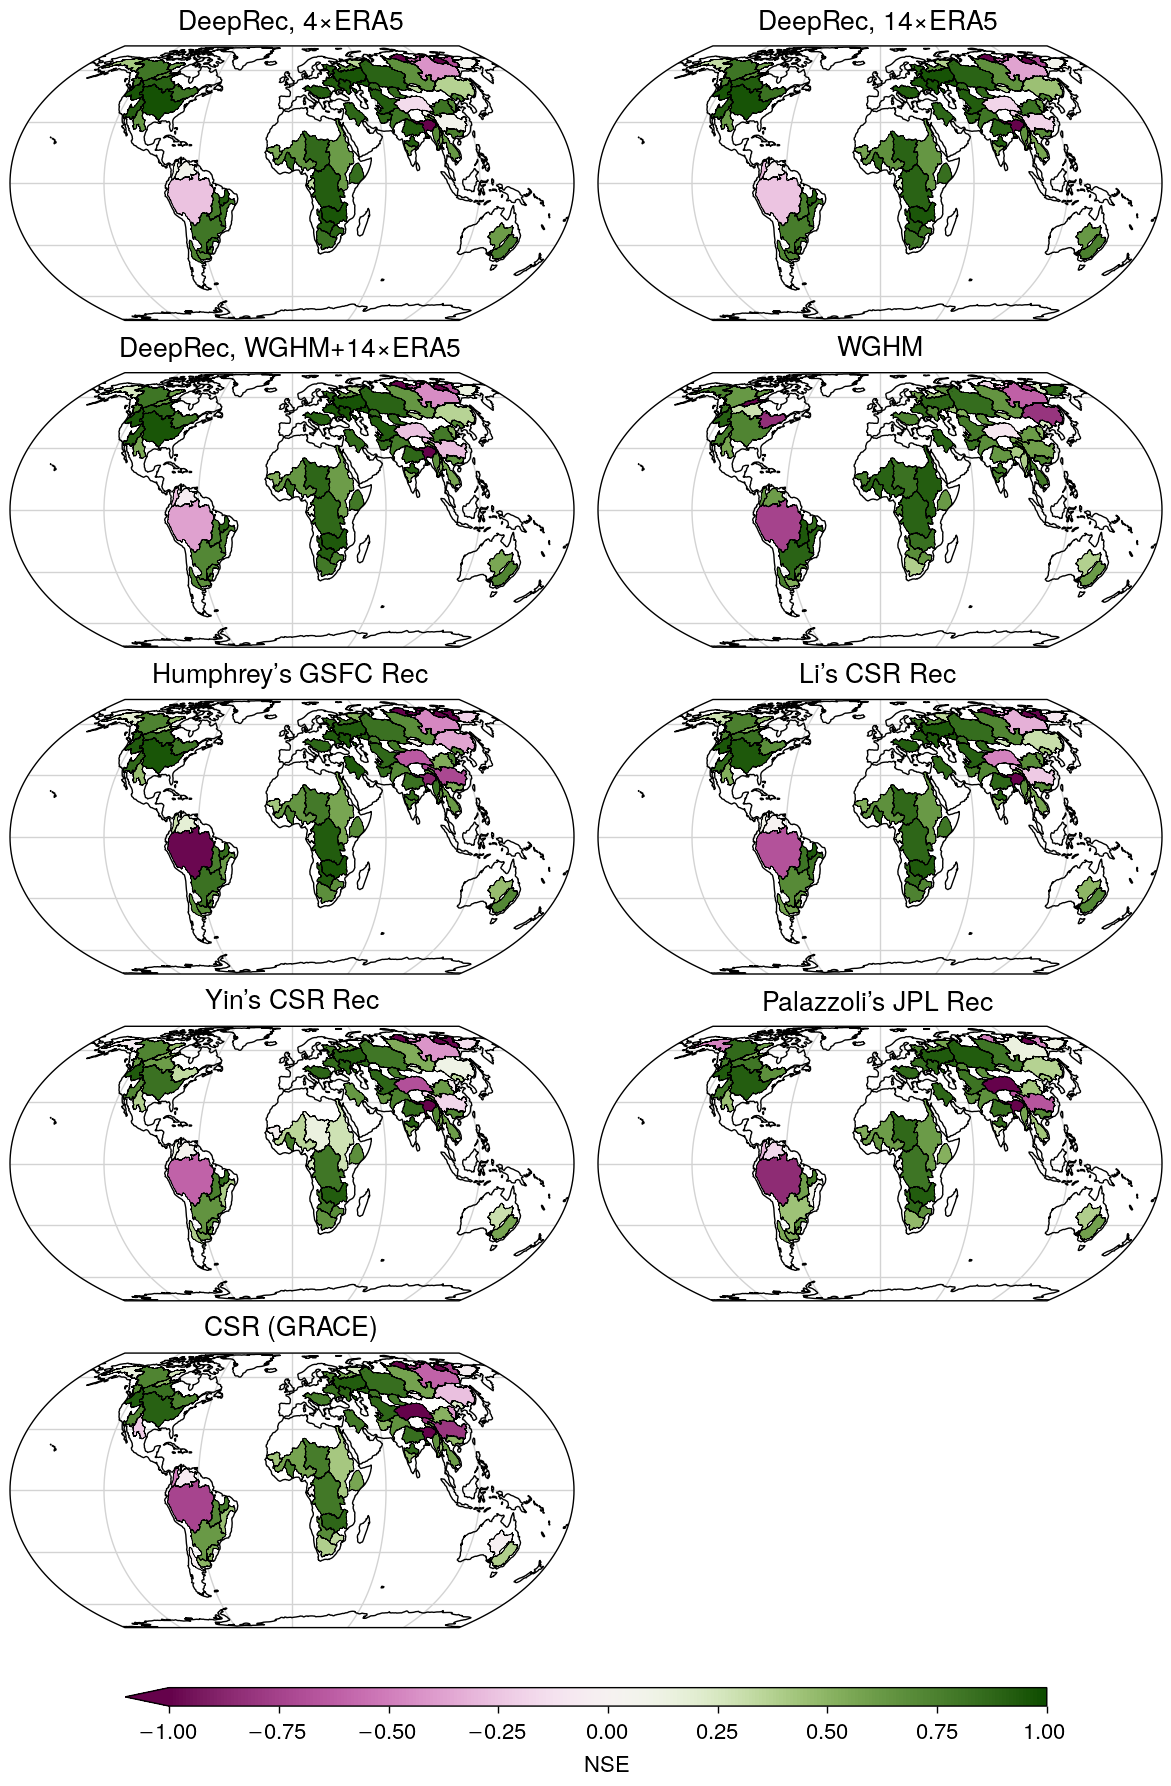

In [12]:
p = da_post_nse.dr.projplot_basins(
    spatial_obj=da_dummy_post, col="model", figsize=(6, 10.25), **plot_kwargs
)

basin_shapes = basins(top=72)
for ax, model in zip(p.axs.flat, da_post_nse.model.values):
    basin_shapes.dr.projplot(ax=ax, **basinlines_kwargs)
    ax.set(title=vars_verbose[model])

p.fig.savefig(
    FIGURE_DIR / f"waterbudget_{times_post[0].year}-{times_post[-1].year}_nse.pdf",
    backend="pgf",
)

In [ ]:
p = da_pre_nse.dr.projplot_basins(
    spatial_obj=da_dummy_pre, col="model", figsize=(6, 8.25), **plot_kwargs
)

basin_shapes = basins(top=72)
for ax, model in zip(p.axs.flat, da_pre_nse.model.values):
    basin_shapes.dr.projplot(ax=ax, **basinlines_kwargs)
    ax.set(title=vars_verbose[model])

p.fig.savefig(
    FIGURE_DIR / f"waterbudget_{times_pre[0].year}-{times_pre[-1].year}_nse.pdf",
    backend="pgf",
)